In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, StandardScaler,QuantileTransformer
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

# Drzewa decyzyjne

Sprawdzają się w sytuacji, gdy zależności nie są liniowe, nie wymagają transformacji

In [2]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

# Trening prostego drzewa o głębokości 3 węzłów

In [3]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor as TreeReg
model = TreeReg(max_depth=3).fit(X,y)

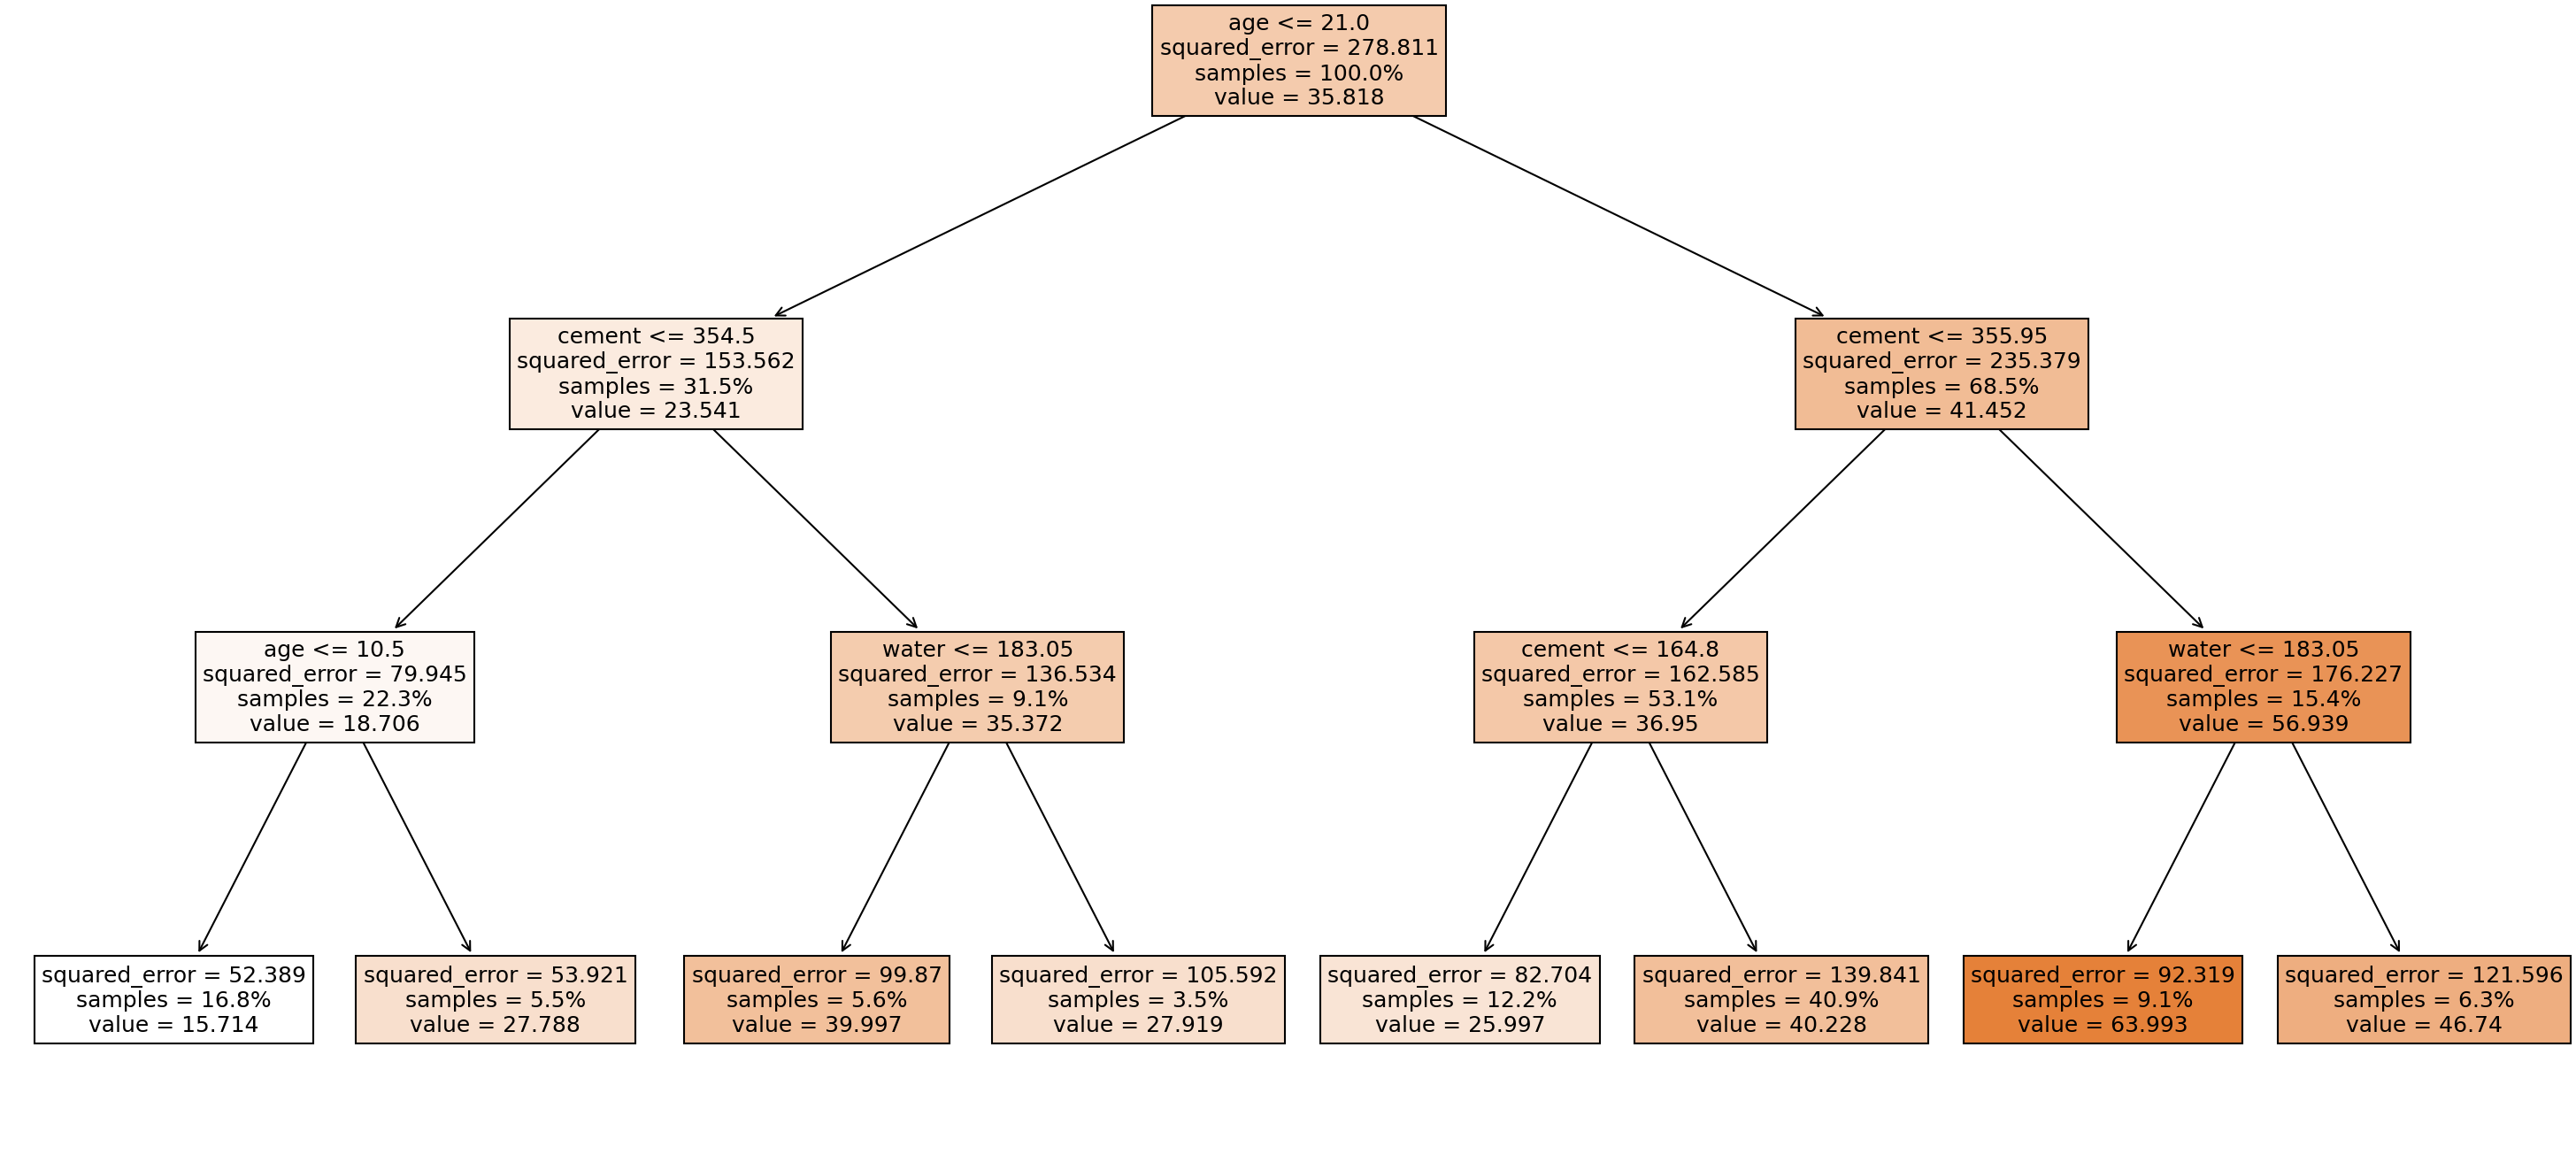

In [11]:
fig,ax=plt.subplots(figsize=(12,6),dpi=150)
ann = tree.plot_tree(model,feature_names=X.columns,ax=ax,filled=True,max_depth=3,fontsize=12,proportion=True) # adnotacje

Obserwujemy różny poziom błędu kwadratowego, oraz wielkości próby. Możemy zastosować jedną z dwóch metod przycinania: *minimalny spadek nieczystości* i e*fektywny parametr alpha*

In [23]:
# ręcznie ustawiamy minimalny spadek nieczystości (tu niedopasowania)
model = TreeReg(min_impurity_decrease=5).fit(X,y)
model.get_n_leaves()

11

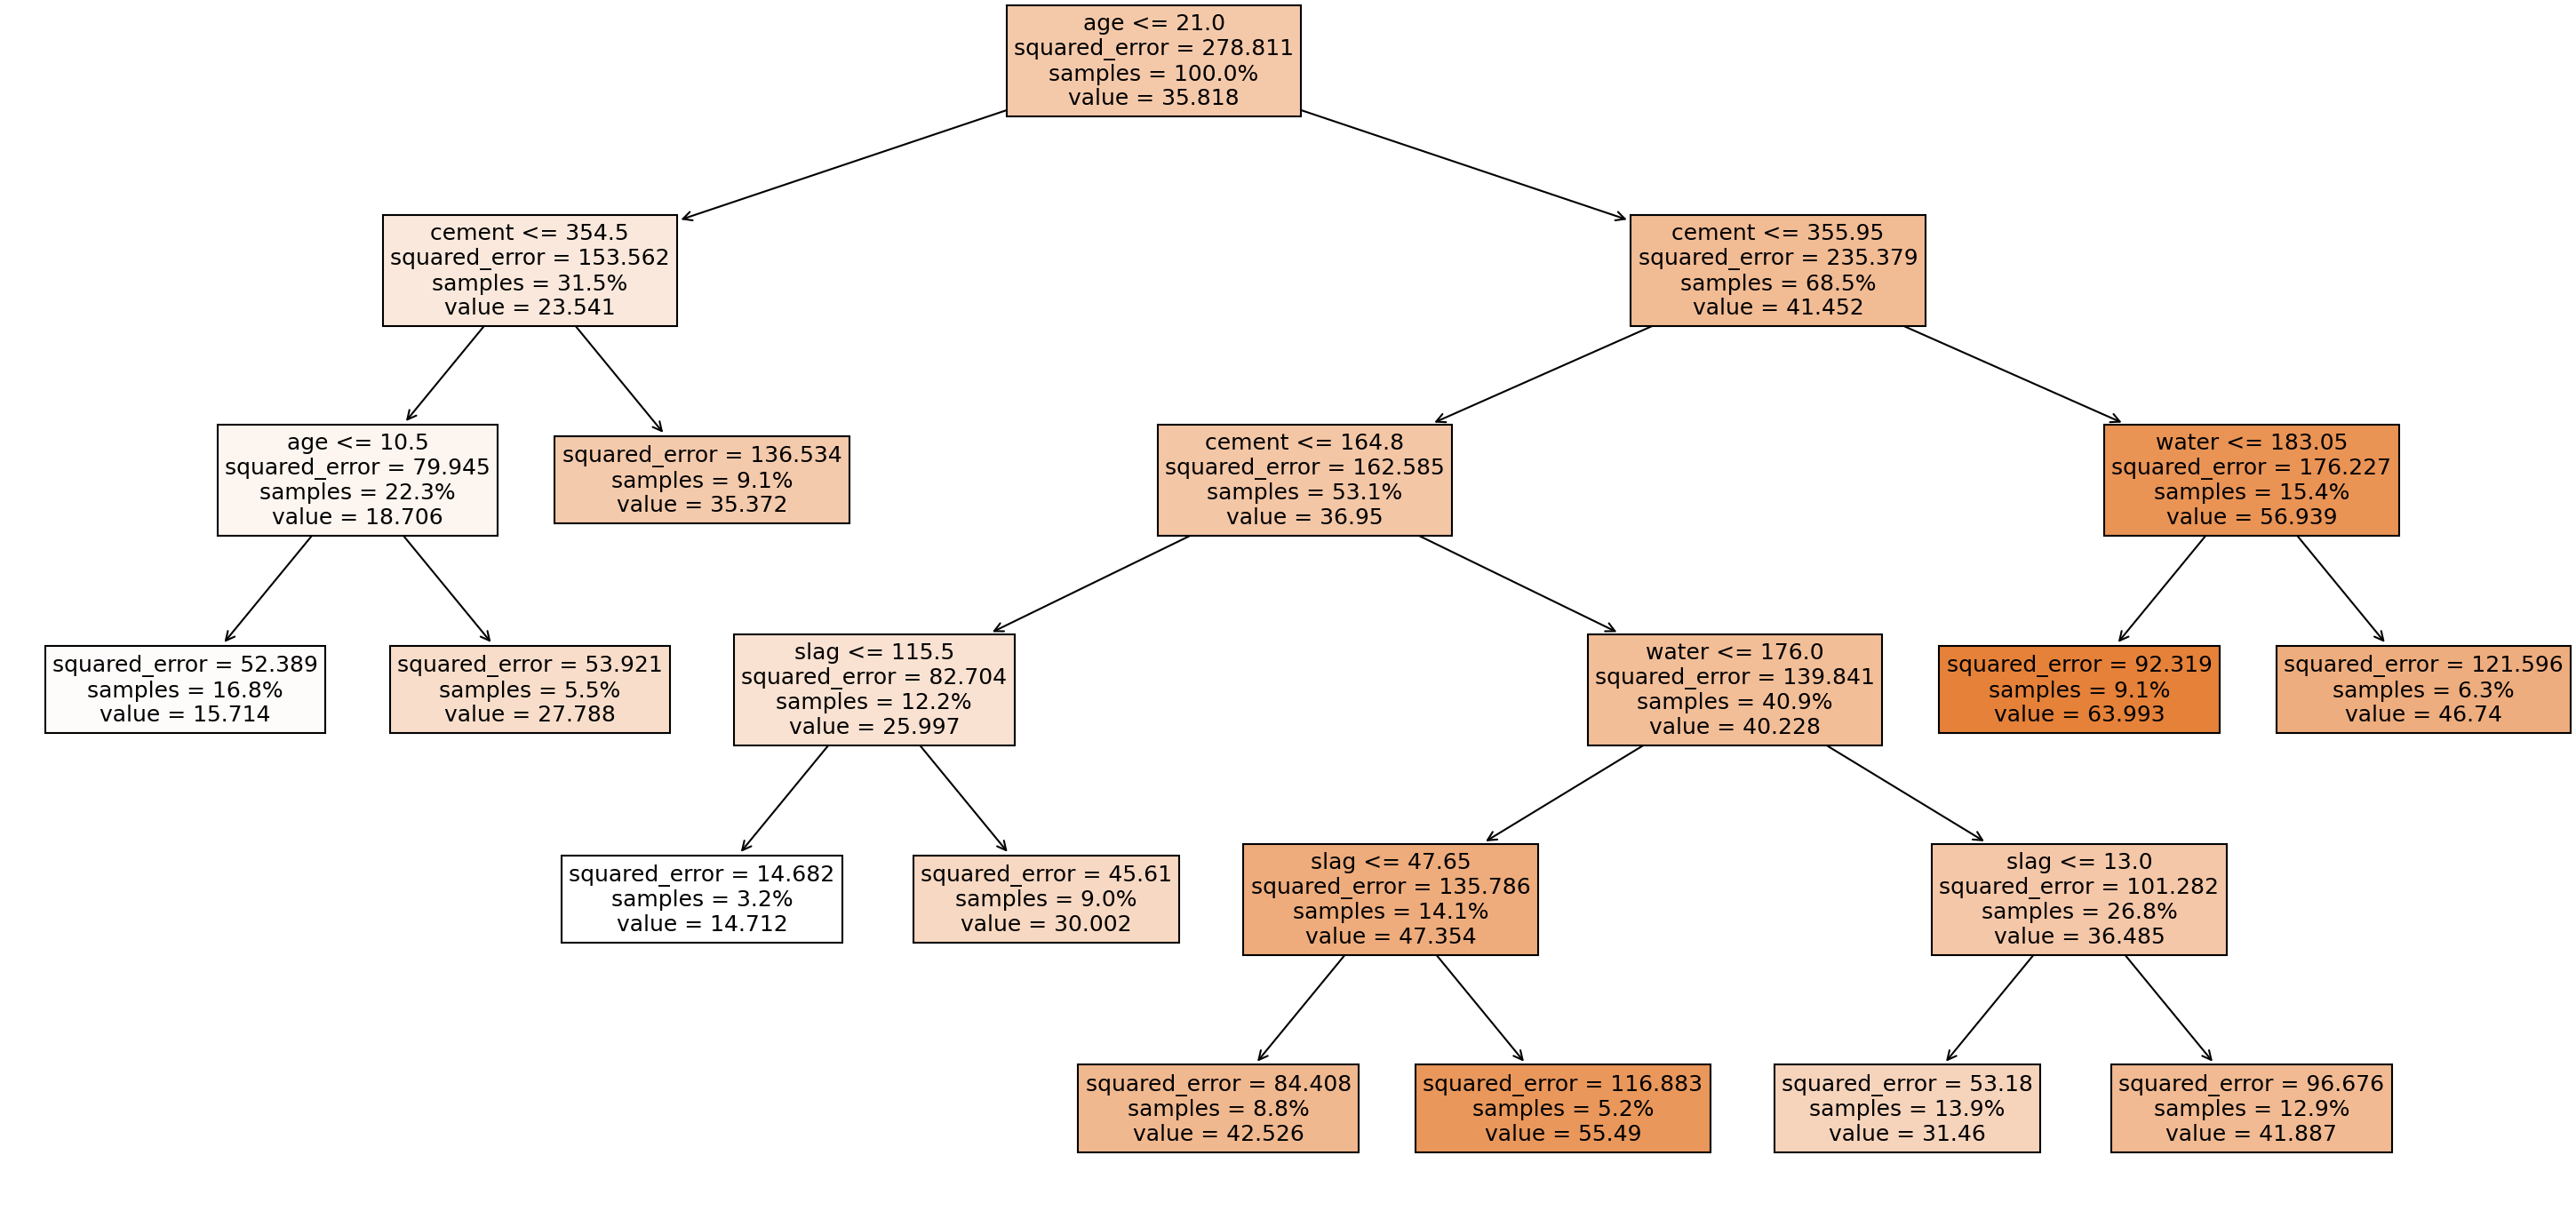

In [24]:
fig,ax=plt.subplots(figsize=(12,6),dpi=150)
ann = tree.plot_tree(model,feature_names=X.columns,ax=ax,filled=True,max_depth=5,fontsize=12,proportion=True)

In [25]:
model = TreeReg().fit(X,y)
model.get_n_leaves()

941

Text(0, 0.5, 'total impurity of leaves')

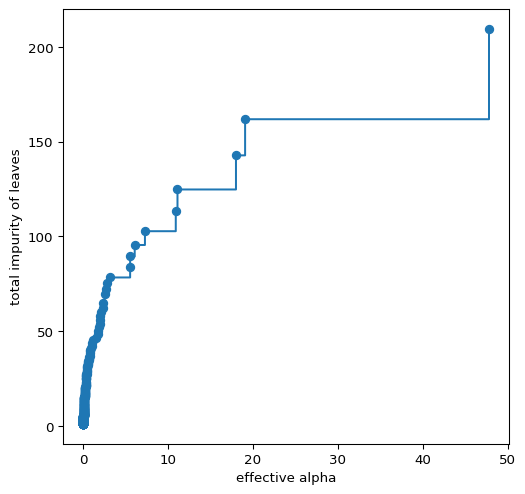

In [29]:
path = model.cost_complexity_pruning_path(X,y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig,ax=plt.subplots(figsize=(6,6),dpi=96)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")

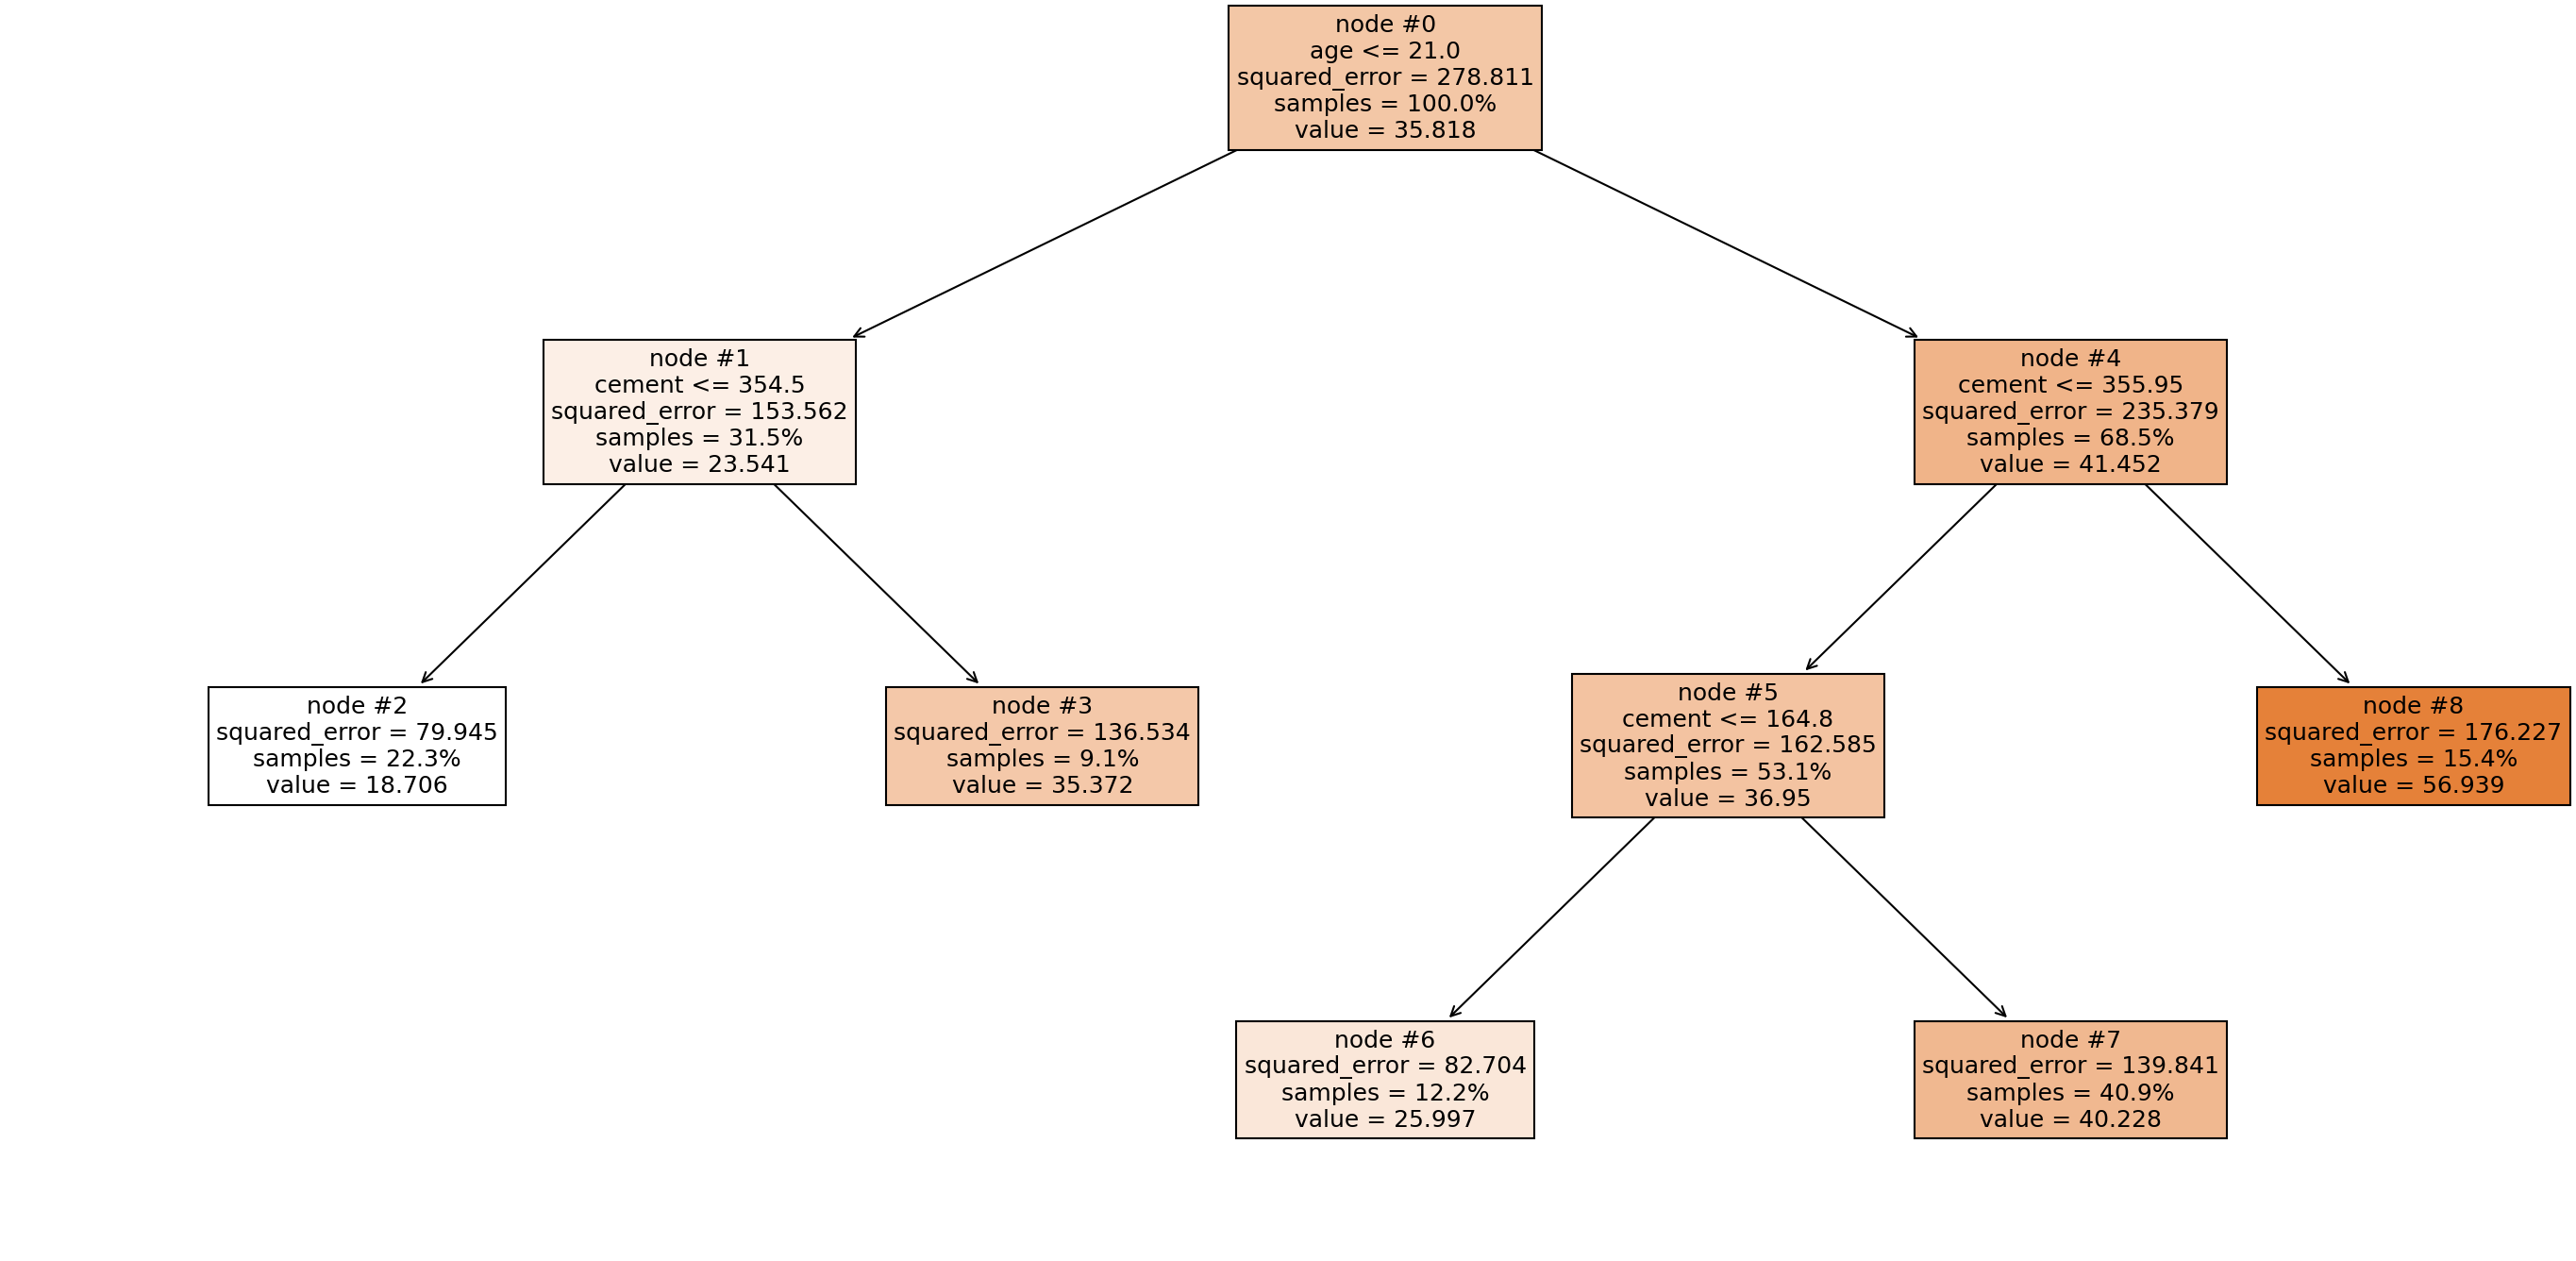

In [39]:
model = TreeReg(ccp_alpha=12).fit(X,y) # sprawdzić inne alpha
model.get_n_leaves()
fig,ax=plt.subplots(figsize=(12,6),dpi=150)
ann = tree.plot_tree(model,feature_names=X.columns,ax=ax,filled=True,max_depth=5,fontsize=12,proportion=True,node_ids=True) # będzie potrzebne

## Współczynniki modeli liniowych dla podzbiorów o lepszym dopasowaniu

Czy jeżeli dopasujemy modele liniowe do podzbiorów o lepszym dopasowaniu to zwiększymy interpretowalność?

In [42]:
from sklearn.linear_model import LinearRegression as ls
coefs = []
leaves = model.apply(X) # apply jest unikalne tylko dla trees
for leave in np.unique(leaves):
    selector = (leaves==leave)
    Xs = X.loc[selector]
    ys = y.loc[selector]
    model = ls().fit(Xs,ys)
    coefs.append(model.coef_)
    

In [46]:
pd.DataFrame(coefs,columns=X.columns,index=np.unique(leaves)).T

,2,3,6,7,8
cement,0.075085,0.095984,-0.014415,0.136151,0.107059
slag,0.035543,0.089835,0.098762,0.142001,0.160706
flyash,0.027004,0.013395,0.018621,0.109083,0.095818
water,-0.086163,-0.309713,-0.140097,0.004947,-0.316061
superplasticizer,0.636924,-0.196053,0.076089,0.787767,-0.574903
coarseaggregate,-0.011153,-0.036205,-0.022241,0.058568,0.002251
fineaggregate,-0.009298,-0.034815,-0.011445,0.057261,0.009512
age,1.143834,2.214185,0.079137,0.066619,0.044570


Podziały głównie ze względu na wiek i cement. Node 6 i 8 dużo cementu i odwrotna zależność od udzialu wody
Wiek tylko dla 3 i 2, gdzie wiek < 21 lat>